In [ ]:
import matplotlib.pyplot as plt
import keras
import pickle
from keras.callbacks import EarlyStopping

In [25]:
pickle_file = './data/data.pkl'

with open(pickle_file, 'rb') as file:
    loaded_data = pickle.load(file)

encoder_input_data = loaded_data['encoder_input_data']
decoder_input_data = loaded_data['decoder_input_data']
decoder_target_data = loaded_data['decoder_target_data']

print("Data loaded from pickle file.")

Data loaded from pickle file.


In [26]:
encoder_input_data = encoder_input_data[:40000]
decoder_input_data = decoder_input_data[:40000]
decoder_target_data = decoder_target_data[:40000]

## Building the model

In [27]:
batch_size = 128  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.

In [28]:
num_encoder_tokens = encoder_input_data.shape[2]
num_decoder_tokens = decoder_input_data.shape[2]

In [29]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [30]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None, 31)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, None, 33)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, 256),     │    294,912 │ input_layer_4[0]… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ [(None, None,     │    296,960 │ input_layer_5[0]… │
│                     │ 256), (None,      │            │ lstm_4[0][1],     │
│                     │ 256), (None,      │            │ lstm_4[0][2]      │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, None, 33)  │      8,481 │ lstm_5[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 600,353 (2.29 MB)

 Trainable params: 600,353 (2.29 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
early_stopping = EarlyStopping(
    monitor='val_loss',    # Metric to monitor (can also be 'val_accuracy' or others)
    patience=3,            # Number of epochs to wait after no improvement
    restore_best_weights=True,  # Restores the best weights after stopping
    min_delta=0.01,         # Minimum change to qualify as an improvement
)

In [32]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=[early_stopping] 
)
# Save model
model.save("./models/s2s_model.keras")

Epoch 1/100


c:\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_18', 'keras_tensor_22']. Received: the structure of inputs=('*', '*')
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 224s 724ms/step - accuracy: 0.5333 - loss: 1.9183 - val_accuracy: 0.6417 - val_loss: 1.2400
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 192s 767ms/step - accuracy: 0.6412 - loss: 1.2226 - val_accuracy: 0.6624 - val_loss: 1.1130
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 188s 753ms/step - accuracy: 0.6678 - loss: 1.0907 - val_accuracy: 0.6808 - val_loss: 1.0413
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 201s 749ms/step - accuracy: 0.6821 - loss: 1.0279 - val_accuracy: 0.6909 - val_loss: 0.9927
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 190s 702ms/step - accuracy: 0.6941 - loss: 0.9814 - val_accuracy: 0.7067 - val_loss: 0.9449
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 202s 702ms/step - accuracy: 0.7105 - loss: 0.9314 - val_accuracy: 0.7223 - val_loss: 0.8990
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 176s 702ms/step - accuracy: 0.7254 - loss: 0.8875 - val_accuracy: 0.7359 - val_loss: 0.8569
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 216s 757ms/step - accuracy: 0.7375 - los

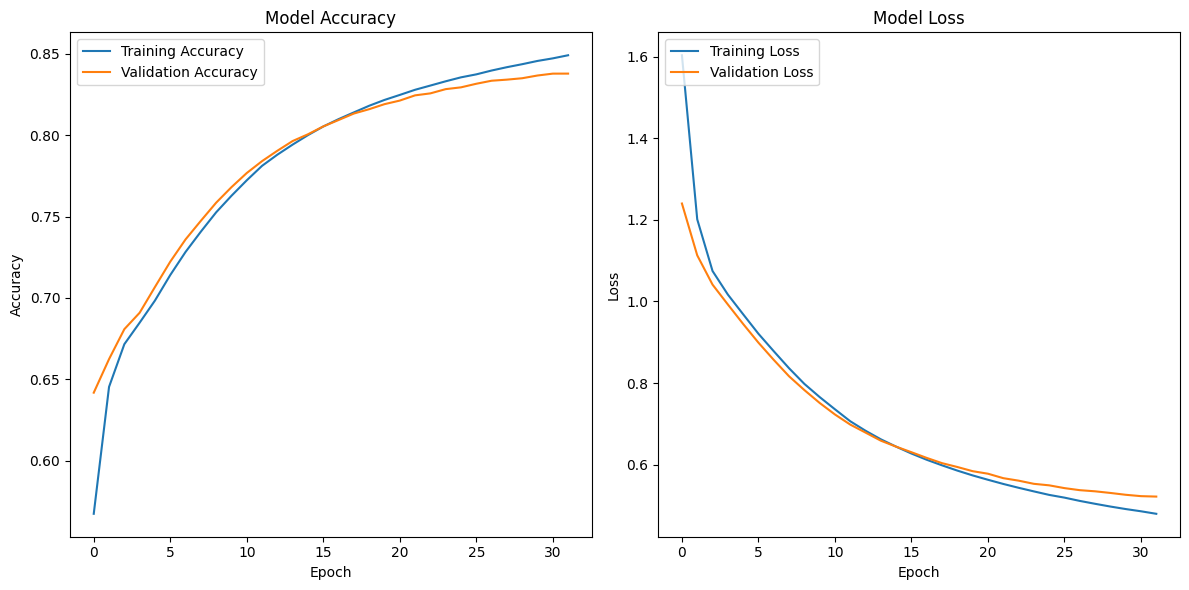

In [35]:
# Plotting training & validation accuracy values
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Show plots
plt.tight_layout()
plt.show()